In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
from numpy.random import normal

In [2]:
N = 10
M = [0, 1, 3, 9]

In [3]:
def create_dataset(num):
    dataset = DataFrame(columns=['x', 'y'])
    for i in range(num):
        x = float(i) / float(num-1) + normal(scale=0.005)
        y = np.sin(2 * np.pi * x) + normal(scale=0.5)
        dataset = dataset.append(Series([x, y], index=['x', 'y']), ignore_index=True)
    return dataset

In [4]:
def log_likelihood(dataset, f):
    dev = 0.0
    n = float(len(dataset))
    for index, line in dataset.iterrows():
        x, y = line.x, line.y
        dev += (y - f(x))**2
    E_d = dev * 0.5
    beta = n / (2 * E_d)
    lp = -beta * E_d + 0.5 * n * np.log(0.5 * beta / np.pi)
    return lp

In [5]:
# directly calc coef with min error
def resolve(dataset, m):
    t = dataset.y
    phi = DataFrame()
    for i in range(0, m+1):
        p = dataset.x**i
        p.name = 'x**%d' % i
        phi = pd.concat([phi, p], axis=1)
    tmp = np.linalg.inv(np.dot(phi.T, phi))
    ws = np.dot(np.dot(tmp, phi.T), t)
    
    def f(x):
        y = 0
        for c, w in enumerate(ws):
            y += w * (x**c)
            #print(f'{c}: {y}')
        return y
    
    sigma2 = 0.0
    for index, line in dataset.iterrows():
        sigma2 += (f(line.x)-line.y)**2
    sigma2 /= len(dataset)
    
    return (f, ws, np.sqrt(sigma2))

In [6]:
train = create_dataset(N)
train

,x,y
0,-0.004001,-0.343973
1,0.112344,0.755002
2,0.218637,0.211105
3,0.332644,1.282031
4,0.447384,0.649128
5,0.554134,-0.485231
6,0.667633,-0.328786
7,0.775476,-1.853290
8,0.881420,-1.175770
9,1.014680,0.724114


In [7]:
test = create_dataset(N)
test

,x,y
0,-0.009235,0.061027
1,0.106022,0.381110
2,0.226612,0.449799
3,0.336024,1.689368
4,0.437163,0.938149
5,0.562912,-0.104793
6,0.660467,-0.717897
7,0.778717,-1.856780
8,0.894613,-0.895166
9,0.995045,0.115062


<ipython-input-8-9c20d6b2ef3c>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


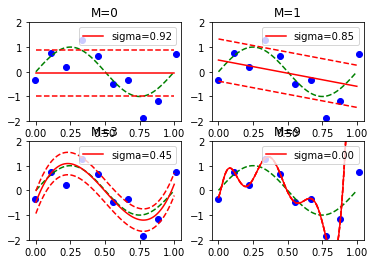

In [8]:
df_ws = DataFrame()
fig = plt.figure()

for i, m in enumerate(M):
    f, ws, sigma = resolve(train, m)
    df_ws = df_ws.append(Series(ws, name=f'M={m}'))
    
    subplot = fig.add_subplot(2, 2, i+1)
    subplot.set_xlim(-0.05, 1.05)
    subplot.set_ylim(-2, 2)
    subplot.set_title(f'M={m}')
    
    subplot.scatter(train.x, train.y, marker='o', color='blue')
    
    linex = np.linspace(0, 1, 101)
    liney = np.sin(2*np.pi*linex)
    subplot.plot(linex, liney, color='green', linestyle='--')
    
    liney = f(linex)
    subplot.plot(linex, liney, color='red', label=f'sigma={sigma:.2f}')
    subplot.plot(linex, liney + sigma, color='red', linestyle='--')
    subplot.plot(linex, liney - sigma, color='red', linestyle='--')
    subplot.legend(loc=1)
    
fig.show()

In [9]:
df = DataFrame()
train_mlh = []
test_mlh = []

for m in range(0, 9):
    f, ws, sigma = resolve(train, m)
    #print(sigma)
    train_mlh.append(log_likelihood(train, f))
    test_mlh.append(log_likelihood(test, f))
df = pd.concat([df, DataFrame(train_mlh, columns=['training']), DataFrame(test_mlh, columns=['test'])], axis=1)
df

,training,test
0,-13.347820,-13.613845
1,-12.607814,-12.205228
2,-12.606513,-12.235236
3,-6.293767,-7.387363
4,-4.079791,-3.812969
5,-4.027313,-4.374079
6,-3.692308,-4.309790
7,-3.334999,-4.645454
8,8.408648,-13.721805


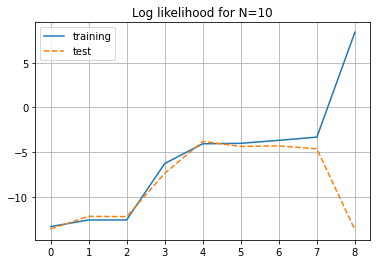

In [10]:
df.plot(title=f'Log likelihood for N={N}', grid=True, style=['-', '--'])
plt.show()